# ECBM 4040 - Assignment 1, Task 3: Dimensionality Reduction

Here is the third part and it is about dimentionality reduction. How to map high-dimentional data into low-dimensional space is an interesting topic in machine learning field. And also, it is related to another hot topic -- unsupervised learning. Now, in this section, you are going to learn two different methods for this question.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [32]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

We will use the CIFAR-10 dataset.

In [33]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

<span style="color:red"><strong>TODO</strong></span>: You have to complete the code in **./ecbm4040/features/pca.py**.

### Naive PCA

In [34]:
from ecbm4040.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [35]:
# Start PCA
K = 200
P, T = pca_naive(X_patch, K)

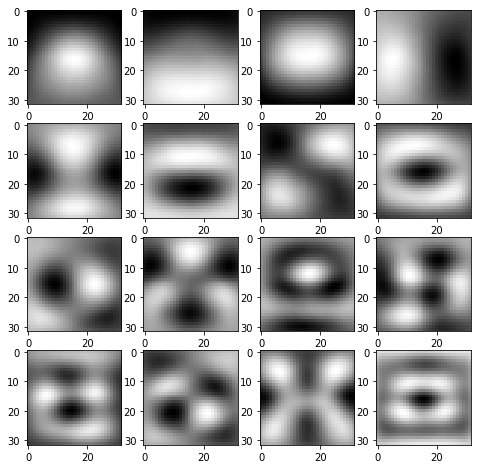

In [25]:
# TODO: Show principle components of P using a 4x4 subplot
# Visualize P
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

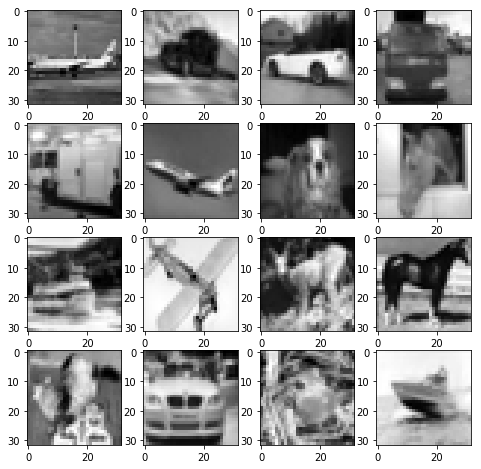

In [26]:
# Select a small set of images for test
num_training = 50000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

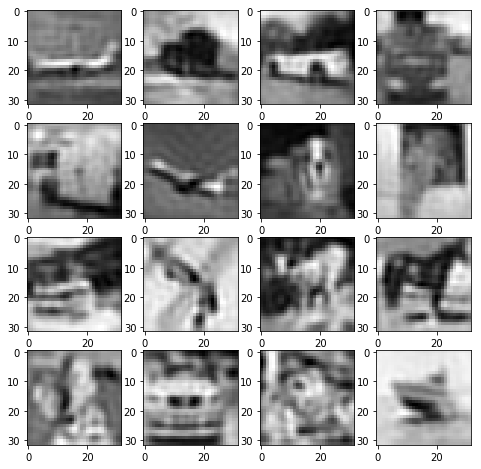

In [27]:
# TODO: Test your result
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

<span style="color:red"><strong>TODO</strong></span>: Use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [43]:
from ecbm4040.train_funcs import train, test
from ecbm4040.classifiers.mlp import MLP

# TODO: pca preprocessing -> mlp classification
model = MLP(input_dim=3072, hidden_dims=[100, 50, 50], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)


X_patch0 = X_train[:,:,:,0]
X_patch0 = np.reshape(X_patch, (X_patch.shape[0], -1))

X_patch1 = X_train[:,:,:,1]
X_patch1 = np.reshape(X_patch, (X_patch.shape[0], -1))

X_patch2 = X_train[:,:,:,2]
X_patch2 = np.reshape(X_patch, (X_patch.shape[0], -1))

K = 200


P0, T0 = pca_naive(X_patch0, K)
feature0 = np.dot(P0, np.matrix(X_patch0).T)

    
P1, T1 = pca_naive(X_patch1, K)
feature1 = np.dot(P1, np.matrix(X_patch1).T)


P2, T2 = pca_naive(X_patch2, K)
feature2 = np.dot(P0, np.matrix(X_patch2).T)

total_transform = np.concatenate([feature0,feature1,feature2], axis = 0)

final_form = np.matrix(total_transform).T


X_train_reduced = final_form[:49000]
X_test_reduced = final_form[49000:59000]
X_val_reduced = final_form[59000:]
test(model, X_train_reduced, y_train)




number of batches for training: 98
5000/49000 loss: 2.3077141017801917
10000/49000 loss: 2.3075860711519196
15000/49000 loss: 2.3073155513391854
20000/49000 loss: 2.3072462781322476
25000/49000 loss: 2.3068774621374692
30000/49000 loss: 2.3068194251280523
35000/49000 loss: 2.306840788267471
40000/49000 loss: 2.3065384804806404
45000/49000 loss: 2.306176764436683
epoch 1: valid acc = 0.128, new learning rate = 0.0095
5000/49000 loss: 2.3060697888884154
10000/49000 loss: 2.3058224778899885
15000/49000 loss: 2.3043721314900965
20000/49000 loss: 2.304445030006472
25000/49000 loss: 2.301689396711879
30000/49000 loss: 2.3011827066498447
35000/49000 loss: 2.3012238046365088
40000/49000 loss: 2.2966219606553078
45000/49000 loss: 2.2888118073232566
epoch 2: valid acc = 0.144, new learning rate = 0.009025
5000/49000 loss: 2.288628570877468
10000/49000 loss: 2.2878532569861783
15000/49000 loss: 2.2611086297610887
20000/49000 loss: 2.281476573056823
25000/49000 loss: 2.2473723582268623
30000/49000

ValueError: shapes (49000,600) and (3072,100) not aligned: 600 (dim 1) != 3072 (dim 0)

<span style="color:red"><strong>TODO</strong></span>: Plot training, validation and test set accuracy.

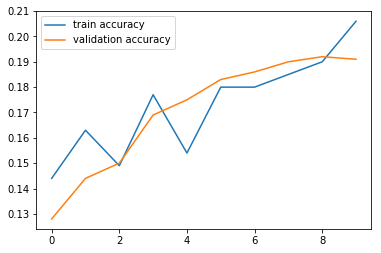

In [44]:
# TODO:
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

## Part 2: t-SNE (not graded)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [45]:
from ecbm4040.features.tsne import tsne

#### tSNE of original data

In [46]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

/home/adi/Downloads/Columbia Acads/Deep Learning/Assignments/assignment1/assignment1/ecbm4040/features/tsne.py:9: RuntimeWarning: divide by zero encountered in log
  H = -np.dot(np.log(P), P)


2.42198781204
The 100 th loop cost: 14.127399775247271, computation time: 3.156024694442749
The 200 th loop cost: 1.1460479541048727, computation time: 6.4078850746154785
The 300 th loop cost: 1.1413121594330136, computation time: 9.637235164642334
The 400 th loop cost: 1.140856978591823, computation time: 12.803011178970337
The 500 th loop cost: 1.1408256818896276, computation time: 16.007192611694336
The 600 th loop cost: 1.1405902871781122, computation time: 19.41912865638733
The 700 th loop cost: 1.1405899881763464, computation time: 22.7011661529541
The 800 th loop cost: 1.1405899854821764, computation time: 25.836450815200806
The 900 th loop cost: 1.1405899854723636, computation time: 29.042531728744507
The 1000 th loop cost: 1.1405899854723223, computation time: 32.2008593082428
it takes 33.54049873352051 seconds


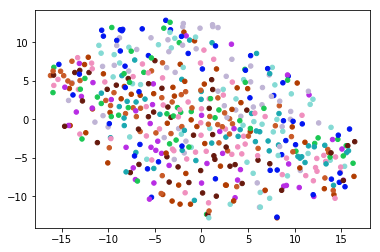

In [47]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, the tSNE of data after two-layer networks is shown as multiple clusters in a 2D panel.

In [48]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-2)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245


/home/adi/Downloads/Columbia Acads/Deep Learning/Assignments/assignment1/assignment1/ecbm4040/layer_funcs.py:148: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


epoch 1: valid acc = 0.316, new learning rate = 0.00095
epoch 2: valid acc = 0.376, new learning rate = 0.0009025
epoch 3: valid acc = 0.405, new learning rate = 0.000857375
epoch 4: valid acc = 0.443, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.461, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.458, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.464, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.463, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.476, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.485, new learning rate = 0.0005987369392383785
test acc: 0.4956


0.49559999999999998

In [49]:
# run tSNE
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 10)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

0.186455833521
The 100 th loop cost: 11.445295940218976, computation time: 3.1021010875701904
The 200 th loop cost: 0.5272706042427889, computation time: 6.291403770446777
The 300 th loop cost: 0.5103159102759735, computation time: 9.407213687896729
The 400 th loop cost: 0.5082047902677151, computation time: 12.556283950805664
The 500 th loop cost: 0.5076900991782435, computation time: 15.8945791721344
The 600 th loop cost: 0.5076321703981779, computation time: 19.109532594680786
The 700 th loop cost: 0.5076221793487509, computation time: 22.31933903694153
The 800 th loop cost: 0.5076205061001062, computation time: 25.610392570495605
The 900 th loop cost: 0.5076202229693264, computation time: 28.717000722885132
The 1000 th loop cost: 0.5076201747885329, computation time: 31.820231676101685
it takes 33.18234157562256 seconds


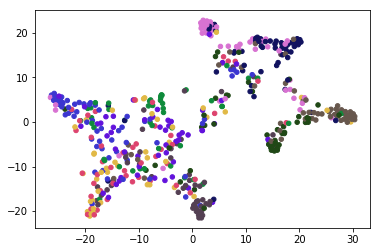

In [50]:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()